# Import

In [79]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [80]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [81]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_1_layout import layout
from util import *

## Set condition

In [82]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [83]:
data_type = "AgNews"
vectorize_types = ["doc2vec"]

In [84]:
model_nums = config["clustering"]["gmm"]["max_model_num"]
covariance_types = config["clustering"]["gmm"]["covariance_types"]
normalization = "normalized"
covariance_types = ["spherical", "diag", "full"]
vector_dims = {
    "doc2vec": config["vectorize"]["doc2vec"]["dims"],
    "sentenceBERT": config["vectorize"]["doc2vec"]["dims"]
}

In [85]:
stats_vals = ["aic", "bic", "mi", "logl"]

# Stats

## Read data

In [86]:
def load_stats_data(vectorize_type, stats_vals, covariance_types, model_nums):
    # データ型定義
    stats = {
        stats_val: {
            covariance_type: {
                model_num: pd.DataFrame for model_num in range(model_nums)
            }
            for covariance_type in covariance_types
        }
        for stats_val in stats_vals
    }

    # データ取得
    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            for model_num in range(model_nums):
                stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{covariance_type}/{model_num}.csv"
                df = pd.read_csv(stats_path, index_col=0)
                stats[stats_val][covariance_type][model_num] = df.loc[:, stats_val]
    return stats

In [87]:
def load_lda_mi(data_type):
    lda_mi = pd.read_csv(
        f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0
    )
    describe_lda_mi, _ = get_describe(lda_mi, axis=0)
    return describe_lda_mi

In [88]:
stats_dict = {}
for vectorize_type in vectorize_types:
    stats_dict[vectorize_type] = load_stats_data(
        vectorize_type, stats_vals, covariance_types, model_nums
    )

In [89]:
describe_lda_mi = load_lda_mi(data_type)

## Data shaping

In [90]:
def shape_stats_df(stats):
    stats_df = {
        stats_val: {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            # model_numについて取得データstatsを結合
            stats_df[stats_val][covariance_type] = pd.concat(
                stats[stats_val][covariance_type], axis=1
            )
    return stats_df

In [91]:
def shape_describe(stats_df):
    describe = {
        stats_val: {covariance_type: dict() for covariance_type in covariance_types}
        for stats_val in stats_vals
    }

    for stats_val in stats_vals:
        for covariance_type in covariance_types:
            describe[stats_val][covariance_type], describe_keys = get_describe(
                stats_df[stats_val][covariance_type], axis=1
            )
    return describe, describe_keys

In [92]:
def shape_data(describe, describe_keys):
    data = {
        stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
        for stats_val in stats_vals
    }
    for stats_val in stats_vals:
        for describe_key in describe_keys:
            # covariance_typeについてデータを結合
            _data = {
                covariance_type: describe[stats_val][covariance_type][describe_key]
                for covariance_type in covariance_types
            }
            data[stats_val][describe_key] = pd.concat(_data, axis=1)
    return data

In [93]:
data_stats = {}
for vectorize_type, stats in stats_dict.items():
    stats_df = shape_stats_df(stats)
    describe, describe_keys = shape_describe(stats_df)
    data_stats[vectorize_type] = shape_data(describe, describe_keys)

In [94]:
stats_df["mi"]["full"].style.highlight_max(axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
2,0.206147,0.224451,0.206176,0.224563,0.209122,0.206145,0.224594,0.224439,0.224601,0.224387,0.206448,0.206235,0.209340,0.224553,0.224584,0.207830,0.224583,0.224503,0.207811,0.206198,0.224485,0.209182,0.206518,0.206175,0.224551,0.206209,0.224515,0.209990,0.206198,0.209587
4,0.377064,0.377571,0.376098,0.371511,0.369713,0.371551,0.370426,0.377537,0.371401,0.371330,0.371200,0.377069,0.377392,0.377735,0.371301,0.371597,0.370404,0.377064,0.370823,0.397174,0.370388,0.377061,0.371335,0.398037,0.371324,0.370965,0.377667,0.371508,0.376995,0.377523
6,0.461595,0.461896,0.461678,0.461761,0.461704,0.461822,0.461648,0.461935,0.461876,0.461748,0.461749,0.461892,0.461676,0.461542,0.461690,0.461762,0.461809,0.461748,0.461628,0.461655,0.461432,0.461751,0.461663,0.461861,0.461725,0.461487,0.461932,0.461884,0.461830,0.461645
8,0.475559,0.475696,0.475272,0.475604,0.475562,0.475105,0.475159,0.475629,0.475222,0.475280,0.475255,0.475173,0.475654,0.475316,0.475591,0.475403,0.475078,0.475756,0.475197,0.475587,0.475188,0.475689,0.475053,0.475353,0.475762,0.475603,0.475291,0.475526,0.475577,0.475259
10,0.466255,0.466761,0.466328,0.466695,0.466783,0.466204,0.466310,0.466221,0.466728,0.466721,0.466737,0.466839,0.466473,0.466427,0.466288,0.466277,0.466755,0.466696,0.466796,0.466746,0.466300,0.466261,0.466291,0.466239,0.466447,0.466232,0.466240,0.466716,0.466814,0.466555
20,0.364962,0.365826,0.422305,0.422213,0.365870,0.420865,0.365722,0.365897,0.363434,0.423359,0.365623,0.365929,0.365738,0.363284,0.365949,0.365864,0.420852,0.420732,0.365896,0.365880,0.420931,0.363286,0.363394,0.363507,0.365318,0.363251,0.363864,0.363288,0.420811,0.363292
40,0.248066,0.249053,0.168275,0.248076,0.249054,0.248592,0.128117,0.226124,0.248673,0.135946,0.249407,0.226144,0.226190,0.161694,0.136762,0.137336,0.133687,0.248744,0.161278,0.222001,0.141630,0.146191,0.226719,0.248278,0.248400,0.248153,0.248747,0.134372,0.248747,0.221618
80,0.167101,0.162621,0.112291,0.159192,0.165566,0.159577,0.165789,0.107233,0.160808,0.167496,0.159787,0.164433,0.160037,0.168099,0.164949,0.168080,0.165615,0.106506,0.161668,0.160379,0.161014,0.165623,0.160312,0.109950,0.164392,0.161464,0.164896,0.165262,0.165010,0.109952
160,0.179601,0.129257,0.139067,0.180066,0.140153,0.178273,0.179868,0.179521,0.140289,0.129439,0.178763,0.129593,0.129605,0.140091,0.122426,0.177502,0.128077,0.119829,0.126690,0.179722,0.178466,0.140501,0.130081,0.126348,0.126648,0.138860,0.129223,0.130292,0.178950,0.139763


# Make Chart

In [95]:
describe = {}
for covariance_type in covariance_types:
    describe[covariance_type], describe_keys = get_describe(stats_df["mi"][covariance_type], axis=1)

In [96]:
describe[covariance_type]["mean"]

2      0.214804
4      0.375292
6      0.461734
8      0.475413
10     0.466504
20     0.379905
40     0.205536
80     0.154503
160    0.147565
dtype: float64

In [97]:
line_labels = {"spherical": "scalar", "diag": "diag", "full": "full"}
xlabel = "埋め込み次元"
ylabel="AMI"
title = {"20News": "A", "AgNews": "B", "AgNewsTitle": "C"}
legend_loc = {"20News": "lower right", "AgNews": "upper right", "AgNewsTitle": "upper right"}

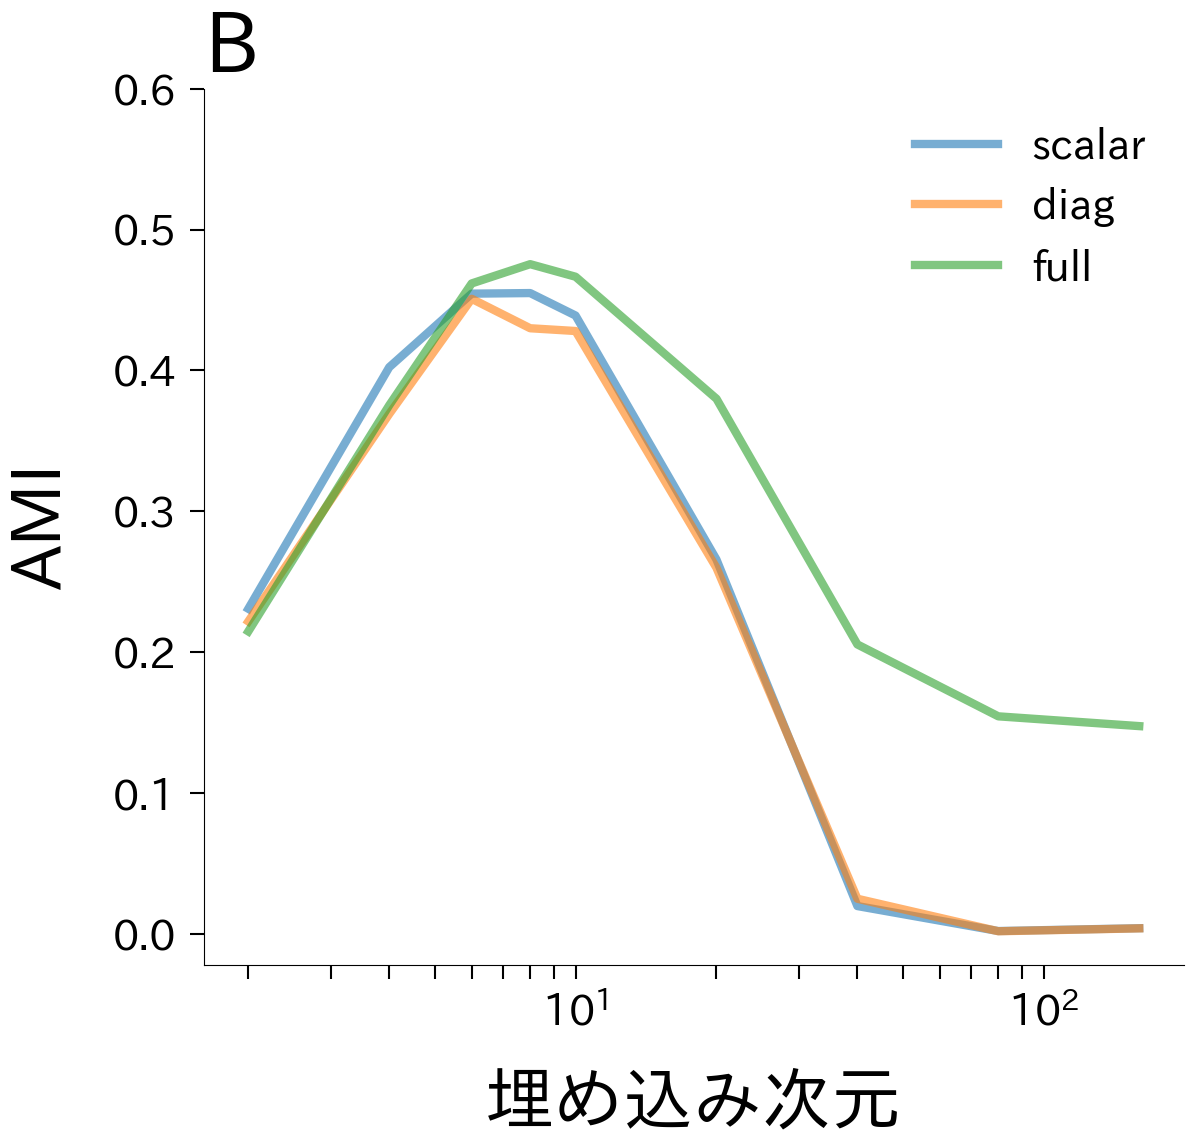

In [98]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111)
fig.subplots_adjust(left=0.2, bottom=0.15)
fig_path = f"../data/figure/{data_type}/Covariance{data_type}.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for covariance_type in covariance_types:
    ax.plot(
        describe[covariance_type]["mean"].index.to_numpy(),
        describe[covariance_type]["mean"].to_numpy(),
        label=f"{line_labels[covariance_type]}",
        alpha=0.6,
        linewidth=6.0,
    )

ax.set_title(title[data_type], fontsize=60, loc="left")

ax.tick_params(which="both", width=1.5, length=8, size=10, direction="out")
ax.xaxis.set_tick_params(labelsize=30, pad=10)
ax.yaxis.set_tick_params(labelsize=30, pad=10)

ax.set_xlabel(xlabel, fontsize=50, labelpad=27, fontweight="black")
ax.set_ylabel(ylabel, fontsize=50, labelpad=27, fontweight="black")
ax.set_yticks(np.arange(0, 0.7, 0.1))
ax.legend(fontsize=30, framealpha=0, loc=legend_loc[data_type])

fig.savefig(make_filepath(fig_path))

In [101]:
describe["diag"]

{'mean': 2      0.221859
 4      0.369106
 6      0.450841
 8      0.429935
 10     0.427972
 20     0.259902
 40     0.025050
 80     0.001967
 160    0.004030
 dtype: float64,
 'median': 2      0.220890
 4      0.363299
 6      0.450795
 8      0.429950
 10     0.427955
 20     0.258360
 40     0.024221
 80     0.001918
 160    0.003981
 dtype: float64,
 'std': 2      0.002289
 4      0.006800
 6      0.000123
 8      0.000089
 10     0.000223
 20     0.005221
 40     0.002584
 80     0.000348
 160    0.000312
 dtype: float64,
 'var': 2      5.240869e-06
 4      4.624334e-05
 6      1.509232e-08
 8      7.964743e-09
 10     4.988487e-08
 20     2.725807e-05
 40     6.679447e-06
 80     1.212871e-07
 160    9.743102e-08
 dtype: float64,
 '75': 2      0.221088
 4      0.376288
 6      0.450948
 8      0.430009
 10     0.428199
 20     0.264217
 40     0.024374
 80     0.002019
 160    0.004005
 Name: 0.75, dtype: float64,
 '25': 2      0.220247
 4      0.362753
 6      0.450769
 8     